## Set-up environment

In [1]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-q690u8vy
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-q690u8vy
  Resolved https://github.com/huggingface/transformers.git to commit e46d21afe2aaf942fd9515b2fba1d6f3affd61a6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 14.8 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-5.0.1.dev0-py3-none-any.whl size=11231143 sha256=9d64192cd3882f8723f80393686f62b5adcdc6ee6cbaeedd76f415f0fb2c7d24
  Stored in directory: /tmp/pip-ephem-wheel-cache-oaqbq3da/wheels/12/51/df/b62c8ce0479c5de6f7bef121169b3e946949a57481169d3155
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.36.0
    Uninsta

In [2]:
!pip install -q datasets

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [3]:
from datasets import load_dataset

dataset = load_dataset("ybelkada/football-dataset", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/371 [00:00<?, ?B/s]

data/train-00000-of-00001-fc7c825a216873(…):   0%|          | 0.00/2.07M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

Let's retrieve the caption of the first example:

In [4]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

And the corresponding image

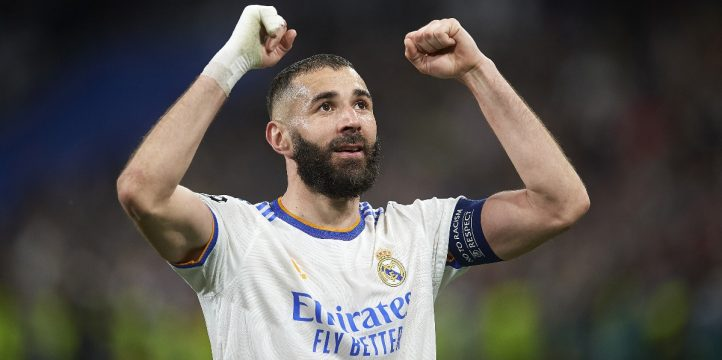

In [5]:
dataset[0]["image"]

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [6]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [7]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/473 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

The tied weights mapping and config for this model specifies to tie text_decoder.cls.predictions.bias to text_decoder.cls.predictions.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BlipForConditionalGeneration LOAD REPORT from: Salesforce/blip-image-captioning-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identic

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [8]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [9]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 13.069734573364258
Loss: 10.22146224975586
Loss: 10.230973243713379
Epoch: 1
Loss: 10.182100296020508
Loss: 10.171303749084473
Loss: 10.139642715454102
Epoch: 2
Loss: 10.152524948120117
Loss: 10.077993392944336
Loss: 10.053528785705566
Epoch: 3
Loss: 10.037482261657715
Loss: 10.07645320892334
Loss: 10.017777442932129
Epoch: 4
Loss: 10.021839141845703
Loss: 9.95705795288086
Loss: 9.754960060119629
Epoch: 5
Loss: 9.004549980163574
Loss: 8.692099571228027
Loss: 8.460681915283203
Epoch: 6
Loss: 8.183536529541016
Loss: 7.968201637268066
Loss: 7.74191951751709
Epoch: 7
Loss: 7.585278034210205
Loss: 7.37559175491333
Loss: 7.184527397155762
Epoch: 8
Loss: 7.0657830238342285
Loss: 6.870683670043945
Loss: 6.753981590270996
Epoch: 9
Loss: 6.587619304656982
Loss: 6.420532703399658
Loss: 6.321911811828613
Epoch: 10
Loss: 6.124481201171875
Loss: 6.026291370391846
Loss: 5.854671001434326
Epoch: 11
Loss: 5.69978666305542
Loss: 5.563286304473877
Loss: 5.415290355682373
Epoch: 12
Loss: 5.256922721

## Inference

Let's check the results on our train dataset

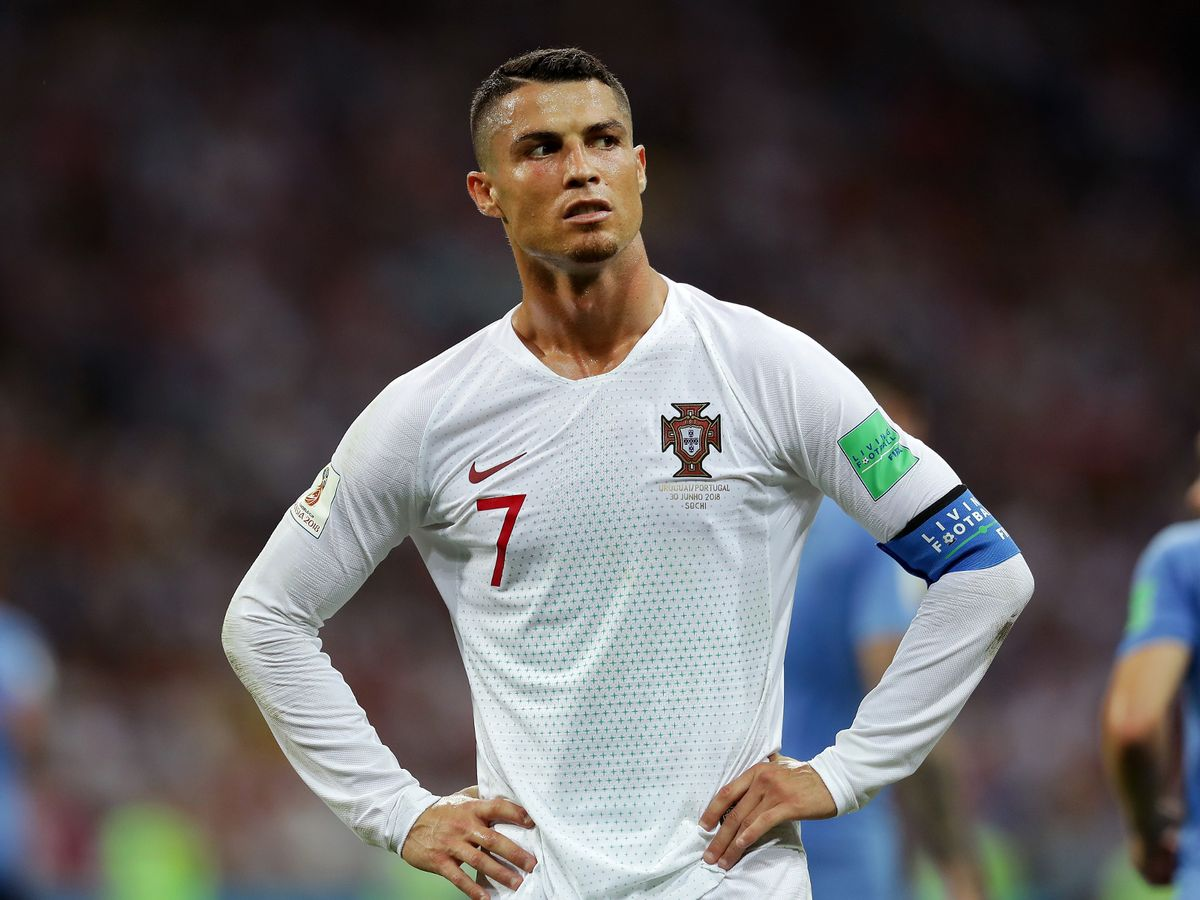

In [10]:
# load image
example = dataset[4]
image = example["image"]
image

In [11]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

ronaldo with portugal at the 2018 world cup
